# Calculating wedge slopes
- Take output from surface_generator
- Extract the section of the wedge before the deformation front
- All measurements are in pixels

# Module imports

In [24]:
import pims
from utils import *

In [25]:
## pjt_slope15_prebuilt_062218, high fric baseline parameters
images = pims.ImageSequence('data/*.jpg')
xmin,xmax,ymin,ymax = 95, 5095,300, 1290 # pixel boundaries of image crop
scale=63. #pixels/cm spatial
im_w=images.frame_shape[1]
im_h=images.frame_shape[0]
surfs = 'pjt_slope15_prebuilt_062218_surfnocv_2023.h5'

# Examine wedge surfaces

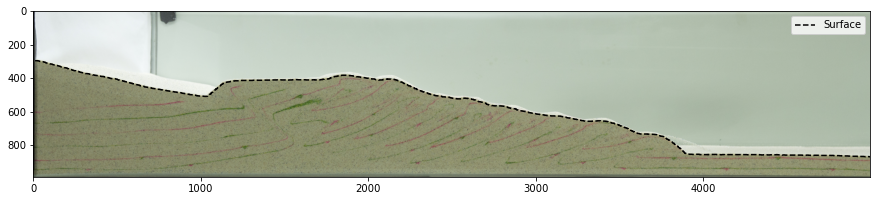

In [26]:
surf = pd.read_hdf(surfs,'wedgetop_00000')
plt.figure(figsize=(15,5))
plt.imshow(images[0][ymin:ymax,xmin:xmax])
plt.plot(surf.x-xmin,-surf.y+im_h-ymin,'k--')
plt.legend(['Surface'])

# Calculate deformation front position
- Use image processing tools to identify curvature in the surface of each wedge

In [27]:
def deformation_front_mode(surfs,xmin,ymax,im_h,far_edge_count=1000,
                           threshold=10,
                           from_larger=True, vergence='s'):
    '''     
    Examine calcuated surfaces, and determine the surface expression of their
        deformation fronts over the length of an experiment.
         
    Perform calcuation on surface with the retrowedge as the first area that 
        exceeds the average flat topography elevation, and the deformation 
        front defined as the last area that exceeds elevation outside of 
        a specifed range of [sand_elev +/- surfvar].
         
    Calcuated value is only the physical expression of the deformation front, 
        as actual deformation may jump forelandward for a short time 
        before surface expression.         
    '''
    surfs_keys = list(h5py.File(surfs,'r'))
    # determine maxlimum width of profile
    len_x = []
    for i, key in enumerate(surfs_keys):    
        surf = pd.read_hdf(surfs,key)
        if from_larger:
            surf.x = surf.x - xmin
            surf.y = surf.y - (im_h-ymax)
        len_x.append(surf.x.max())
    width = int(max(len_x))    
    
    # place surface in preallocated array
    surface = np.zeros((len(surfs_keys),width))
    for i, key in enumerate(surfs_keys):    
        surf = pd.read_hdf(surfs,key)
        surf = surf.y.dropna().reindex(surf.x, method='nearest').reset_index()
        if from_larger:
            surf.x = surf.x - xmin
            surf.y = surf.y - (im_h-ymax)
        surface[i,np.array(surf.x.values,dtype='int')-1] = surf.y.values
        
    # determine mean height of foreland material on far edge of surface array
    far_edge_mean = surface[:,-far_edge_count:].mean()
    # mask to find area that is within a given elevation of this mean
    mask = (surface > far_edge_mean - threshold) & \
                (surface < far_edge_mean + threshold)
    # set boolean mask on edges to remove edge effects
    mask[:,-far_edge_count:] = True
    
    # different modes for either style of model
    if vergence == 's':
        edge = nd.filters.sobel(mask.astype(float))
        front = []
        for i in range(edge.shape[0]):
            if len(edge[i,:][edge[i,:] > 0]):
                front_loc = np.nonzero(edge[i,:])[0][-1]
                front.append([i,front_loc])
            else:
                front.append([i,np.nan])
        front = pd.DataFrame(front,columns=('frame','x_df'))
    if vergence == 'd':
        mask[:,:far_edge_count] = True
        edge = nd.filters.sobel(mask.astype(float))
        front = []
        for i in range(edge.shape[0]):
            if len(edge[i,:][edge[i,:] > 0]):
                retro_loc = np.nonzero(edge[i,:])[0][0]
                front_loc = np.nonzero(edge[i,:])[0][-1]
                front.append([i,retro_loc,front_loc])
            else:
                front.append([i,np.nan,np.nan])
        front = pd.DataFrame(front,columns=('frame','x_rf','x_df'))
    elif vergence != 's' and vergence != 'd':
        raise ValueError('Choose either singly (s) or doubly (d) vergent mode') 
    return front

In [36]:
front = deformation_front_mode(surfs,xmin,ymax,im_h)
front

,frame,x_df
0,0,3795
1,1,3795
2,2,3795
3,3,3792
4,4,3789
5,5,3786
6,6,3783
7,7,3780
8,8,3782
9,9,3782


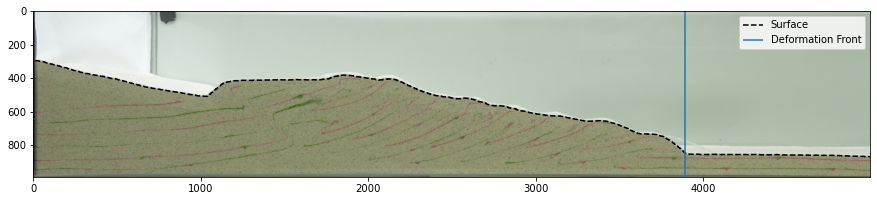

In [35]:
plt.figure(figsize=(15,5))
plt.imshow(images[0][ymin:ymax,xmin:xmax])
plt.plot(surf.x-xmin,-surf.y+im_h-ymin,'k--')
plt.vlines(front.iloc[0].x_df+xmin,0,ymax-ymin)
plt.ylim(ymax-ymin,0)
plt.legend(['Surface','Deformation Front'])

# Fit surface of wedge
- Here we are demarcating the wedge as any material between the backstop (i.e., x=0) and the deformation front.
- The defintition of the active wedge is changable, and others may define the wedge as the material between the first interruption in topography (~1000 pixels across the image) and the deformation front.

In [31]:
slopes = slope_deffront(surfs,front,plotting=True)

![alt text](fit_surf_wedgetop_00000.png)

- Here we see that the average slope of the wedge is roughly 5.5 degrees from horizontal.